In [1]:
from config import *
from utilities.qcbm import ArbitraryRotation, CNOTEntangler, BlockQueue, QCBM
from utilities.kernels import RBFMMD2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.optimize import minimize
from scipy.stats import beta, entropy, wasserstein_distance

In [3]:
def get_nn_pairs(num_bit):
    '''get nearest neighbor pairs (CNOTs are applied to these pairs).'''
    res = []
    for inth in range(2):
        for i in range(inth, num_bit, 2):
            res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
    return res

def get_circuit(num_bit, depth, pairs):
    '''Get the qcbm circuit with given number of qubits, depth and CNOT pairs'''
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbitraryRotation(num_bit))
        if idepth!=depth:
            blocks.append(CNOTEntangler(num_bit, pairs))
    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

In [4]:
def train(bm, theta_list, method, max_iter=1000, step_rate=0.1):
    '''
    train a Born Machine.

    Args:
        bm (QCBM): quantum circuit born machine training strategy.
        theta_list (1darray): initial parameters.
        method ('COBYLA'): optimization method
        max_iter (int): maximum allowed number of iterations.
        step_rate (float): learning rate for Adam optimizer.

    Returns:
        (float, 1darray): final loss and parameters.
    '''
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], bm.mmd_loss(x)))

    theta_list = np.array(theta_list)
    res = minimize(bm.mmd_loss, x0=theta_list, method=method, tol=1e-12,
                   options={'maxiter': max_iter, 'disp': 0},callback=callback,)
    return res.fun, res.x

In [5]:
alpha = 2
beta_ = 2
m = 2
depth = 2
a = 0
b = 1

In [6]:
p_i_set = beta.pdf(np.linspace(a, b, 2**m), alpha, beta_)
p_i_set /= p_i_set.sum()

In [7]:
pairs = get_nn_pairs(m)
circuit = get_circuit(m, depth, pairs)
mmd = RBFMMD2(sigma_list=[1,2], basis=np.arange(2**m))
bm = QCBM(circuit, mmd, p_i_set, batch_size=None)

In [8]:
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'COBYLA', max_iter=99)
pl = bm.pdf(theta_list)

step = 1, loss = 0.13140910412120765
step = 2, loss = 0.19356381671783268
step = 3, loss = 0.18225867002008483
step = 4, loss = 0.1772810062479361
step = 5, loss = 0.17728100624793597
step = 6, loss = 0.17466278852027262
step = 7, loss = 0.08582329300911859
step = 8, loss = 0.1557086624684721
step = 9, loss = 0.3086000339414774
step = 10, loss = 0.10497495567623039
step = 11, loss = 0.10497495567623041
step = 12, loss = 0.07079778827707528
step = 13, loss = 0.048308292014367815
step = 14, loss = 0.031225104360138548
step = 15, loss = 0.2588471892880008
step = 16, loss = 0.02507223742718646
step = 17, loss = 0.09536743861195045
step = 18, loss = 0.06858855761285666
step = 19, loss = 0.03735901059450932
step = 20, loss = 0.018719187187583235
step = 21, loss = 0.019062430891333547
step = 22, loss = 0.018543189118443836
step = 23, loss = 0.04255806358439193
step = 24, loss = 0.03177193866585811
step = 25, loss = 0.14168333957184076
step = 26, loss = 0.02577101244521338
step = 27, loss = 0.

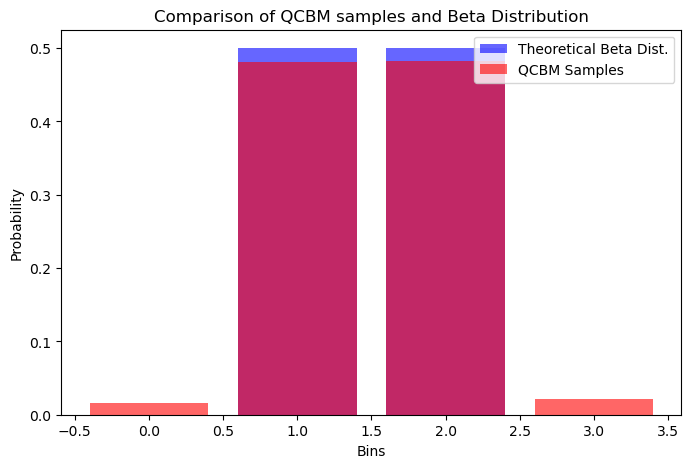

In [9]:
plt.figure(figsize=(8, 5))
plt.bar(range(len(p_i_set)), p_i_set, alpha=0.6, label='Theoretical Beta Dist.', color='blue')
plt.bar(range(len(pl)), pl, alpha=0.6, label='QCBM Samples', color='red')
plt.xlabel("Bins")
plt.ylabel("Probability")
plt.legend()
plt.title("Comparison of QCBM samples and Beta Distribution")
plt.show()

In [10]:
print("try:", p_i_set)

try: [0.  0.5 0.5 0. ]


In [11]:
print("gen:", pl)

gen: [0.01574291 0.48073658 0.48253562 0.02098489]


In [12]:
emd = wasserstein_distance(pl, p_i_set)
print(f"Earth Mover's Distance: {emd}")
print(f"final loss: {loss}")

Earth Mover's Distance: 0.018363902340181915
final loss: 0.001198474296301711
